# Benchmarking DeLOB

In [1]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import numpy as np
import os
from seqwalk import design
from time import time, sleep
import subprocess
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import resource

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
lib_size = np.logspace(3, 5.3, 20, dtype=int)
print(lib_size)

d = {
    "Candidate space" : [],
    "Preprocessing time" : [],
    "BLAST time" : [],
    "Number of BLAST records" : [],
    "Network elimination time" : [],
    "Total time" : [],
    "Library size" : [],
    "Peak memory usage (GB)" : []
}

for N in tqdm(lib_size):

    t0 = time()
    
    # generate random seqs
    lib = ["".join(np.random.choice(["A", "C", "G", "T"], size=25)) for _ in range(N)]
    
#     save as FASTA
    seqs = [SeqRecord(Seq(lib[l]), id="seq%d"%l) for l in range(len(lib))]
    SeqIO.write(seqs, "seqs.fasta", "fasta")
    t1 = time()

    cmd= 'blastn -query seqs.fasta -subject seqs.fasta -outfmt 6 -out res -dust no -word_size 11'
    cmd = cmd.split()
    subprocess.Popen(cmd).wait()
    df = pd.read_csv("res", sep='\t', header=None)
#     # only perfect identity
#     df = df[df[2] == 100]
#     # remove identical
#     df = df[df[3] != 25]
#     # remove high HSP
#     df = df[df[3] < 13]

    t2 = time()

    trashbin = set()
    keeper = set()
    for row in df.iterrows():
        if row[1][3] < 13 and row[1][3] != 25: 
            query = row[1][0]
            target = row[1][1]
            if query not in keeper:
                if query not in trashbin:
                    keeper.add(query)
                    trashbin.add(target)
            else:
                trashbin.add(target)

    t3 = time()
    d["Candidate space"].append(N)
    d["Preprocessing time"].append(t1-t0)
    d["Number of BLAST records"].append(len(df))
    d["BLAST time"].append(t2-t1)
    d["Network elimination time"].append(t3-t2)
    d["Total time"].append(t3-t0)
    d["Library size"].append(len(keeper))
    mem = resource.getrusage(resource.RUSAGE_CHILDREN).ru_maxrss/10**6
    d['Peak memory usage (GB)'].append(mem)
#     print("Memory usage (GB): %f" % mem)

[  1000   1321   1746   2307   3049   4029   5324   7036   9298  12287
  16237  21457  28355  37470  49515  65431  86465 114260 150989 199526]


  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
pd.DataFrame(d)

,Candidate space,Preprocessing time,BLAST time,Number of BLAST records,Network elimination time,Total time,Library size,Peak memory usage (GB)
0,1000,0.024374,0.139897,1095,0.027343,0.191614,39,0.195604
1,1321,0.025997,0.144057,1474,0.033399,0.203453,61,0.198676
2,1746,0.033313,0.188991,1978,0.045523,0.267827,99,0.200232
3,2307,0.043087,0.255490,2757,0.056088,0.354666,183,0.202280
4,3049,0.056480,0.340504,3815,0.083678,0.480662,319,0.203388
5,4029,0.113726,0.492534,5401,0.120029,0.726290,537,0.210404
6,5324,0.097184,0.687502,7658,0.164373,0.949059,902,0.305516
7,7036,0.179024,0.971694,11234,0.250408,1.401126,1477,0.478744
8,9298,0.228592,1.448868,16782,0.372071,2.049531,2434,0.839328
9,12287,0.224918,2.052507,24986,0.585409,2.862834,3798,1.107348


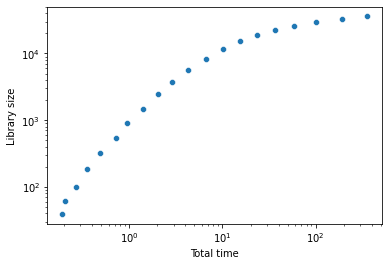

In [4]:
res_df = pd.DataFrame(d)

sns.scatterplot(res_df,
             y="Library size",
             x="Total time")
plt.xscale('log')
plt.yscale('log')

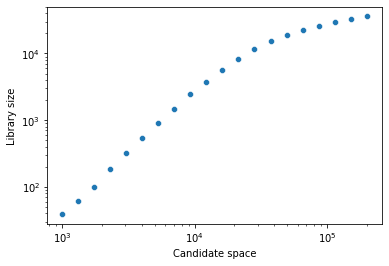

In [5]:
sns.scatterplot(res_df,
             x="Candidate space",
             y="Library size")
plt.xscale('log')
plt.yscale('log')

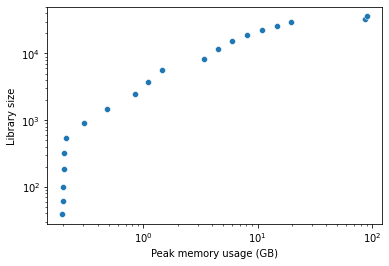

In [12]:
res_df = pd.DataFrame(d)

sns.scatterplot(res_df,
             y="Library size",
             x="Peak memory usage (GB)")

plt.xscale('log')
plt.yscale('log')

In [7]:
res_df.to_csv("DeLOB_benchmarking.csv")

In [8]:
t0 = time()
library = design.max_size(25, 12, alphabet="ACGT", prevented_patterns=[])
t1 = time()

mem = resource.getrusage(resource.RUSAGE_CHILDREN).ru_maxrss/10**6
print(mem)
print(t1-t0)

90.02178
15.443267345428467


In [9]:
sw_time = t1-t0
sw_ls = len(library)
print(sw_ls)

1198372


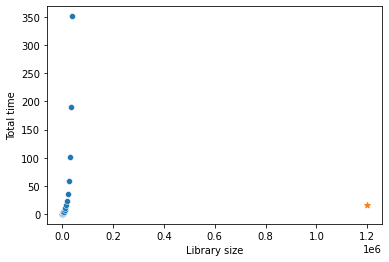

In [10]:
sns.scatterplot(res_df,
             x="Library size",
             y="Total time")
plt.scatter([sw_ls],[sw_time],  marker="*")
# plt.yscale('log')

In [11]:
res_df

,Candidate space,Preprocessing time,BLAST time,Number of BLAST records,Network elimination time,Total time,Library size,Peak memory usage (GB)
0,1000,0.024374,0.139897,1095,0.027343,0.191614,39,0.195604
1,1321,0.025997,0.144057,1474,0.033399,0.203453,61,0.198676
2,1746,0.033313,0.188991,1978,0.045523,0.267827,99,0.200232
3,2307,0.043087,0.255490,2757,0.056088,0.354666,183,0.202280
4,3049,0.056480,0.340504,3815,0.083678,0.480662,319,0.203388
5,4029,0.113726,0.492534,5401,0.120029,0.726290,537,0.210404
6,5324,0.097184,0.687502,7658,0.164373,0.949059,902,0.305516
7,7036,0.179024,0.971694,11234,0.250408,1.401126,1477,0.478744
8,9298,0.228592,1.448868,16782,0.372071,2.049531,2434,0.839328
9,12287,0.224918,2.052507,24986,0.585409,2.862834,3798,1.107348
